# Periodic orbits of Lorenz system

We calculate periodic orbits of the Lorenz sysetem from approximate fixed points in the return maps on the Poincare section.

In [1]:
using Plots
using LinearAlgebra

Preliminary code defining Lorenz system, its EQBs, its Jacobian, and a Rung-Kutta integration function

In [2]:
# Define functions for EQ1, the flow f(x), and the Jacobian Df(x)
# all parameterized by σ, β, ρ

EQ0 = [0.0; 0.0; 0.0]

function EQ1(σ, β, ρ) 
    if ρ <= 1
        return [0.0; 0.0; 0.0]
    else
        return [sqrt(β*(ρ-1)); sqrt(β*(ρ-1)); ρ-1]
    end
end

function lorenz(x, σ, β, ρ)
    dxdt = σ*(x[2] - x[1])
    dydt =  ρ*x[1] - x[2] - x[1]*x[3]
    dzdt = -β*x[3] + x[1]*x[2]
    
    [dxdt; dydt; dzdt]
end

function lorenz_Jacobian(x, σ, β, ρ)
    [ -σ      σ     0   ; 
     ρ-x[3]  -1   -x[1] ;
     x[2]    x[1]  -β   ]
end

# From the above, build functions that compute eigvals at
# origin and EQ1
σ = 10; β = 8/3

eq0eigs(ρ) = eigvals(lorenz_Jacobian(EQ0, σ, β, ρ))
eq1eigs(ρ) = eigvals(lorenz_Jacobian(EQ1(σ, β, ρ), σ, β, ρ))

function rungekutta4(f, x₀, Δt, T) 
   
    # fix up Δt so it evenly divides time interval
    N = convert(Int64, round(T/Δt))
    #Δt = (t₁ - t₀)/N
    Δt2 = Δt/2
    Δt6 = Δt/6
    t = (0:N)*Δt

    x = zeros(N+1, length(x₀))
    x[1,:] = x₀

    for n = 1:N
        xn = x[n,:]
        tn = t[n]
        s1 = f(xn)
        s2 = f(xn + Δt2*s1)
        s3 = f(xn + Δt2*s2)
        s4 = f(xn + Δt *s3)

        x[n+1, :] =  xn + Δt6*(s1 + 2s2 + 2s3 + s4) # RK4 update formula
    end
    t,x
end

rungekutta4 (generic function with 1 method)

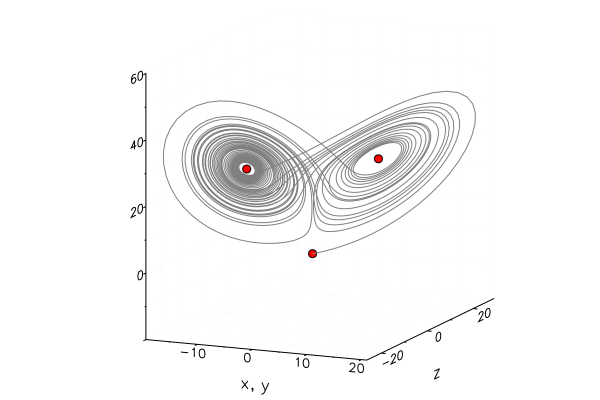

In [3]:
# Plot the three EQBs and EQ0's unstable manifold

σ = 10
β = 8/3
ρ = 28
T = 40

# equilibrium points
eq0 = [0.0; 0.0; 0.0]
eq1 = EQ1(σ, β, ρ)
eq2 = [-eq1[1]; -eq1[2]; eq1[3]]

ϵ = 1e-02
Δt = 0.01

# construct f(x) and Df(x) functions for given vals of σ, β, ρ
f(x) = lorenz(x, σ, β, ρ)
Df(x) = lorenz_Jacobian(x, σ, β, ρ)

# compute leading eigenvector of Df at origin
Λ,V = eigen(Df(eq0))
p = sortperm(real(Λ), rev=true) # find largest eigval
v = V[:,p[1]]
    
# plot the eqbs
plot([eq0[1]], [eq0[2]], [eq0[3]], marker=:circ, color=:red)
plot!([eq1[1]], [eq1[2]], [eq1[3]], marker=:circ, color=:red)
plot!([eq2[1]], [eq2[2]], [eq2[3]], marker=:circ, color=:red)
    
# plot trajectories in unstable manifold of origin
x₀ = eq0 - ϵ*v
t,x = rungekutta4(f, x₀, Δt, T)
plot!(x[:,1], x[:,2], x[:,3], color=:grey)
plot!(legend=false, xlabel="x, y", ylabel="z")

Define a few functions for calculating successive intersections of a trajectory $x(t)$ with the Poincare section $h(x) = 0$.

In [4]:
# Classic Lagrange interpolation function needed for finding the intersection
# of a trajectory with the Poincare section. 

# interpolate y(x) at x = x̂, given vectors of y and x data
function interpolate(y, x, x̂)
    N = length(x)
    ŷ = zero(y[1,:])
    
    for i=1:N
        numer = 1.0;
        denom = 1.0;
        for j=1:N
            if i == j
                continue
            end
            numer *= x̂ - x[j]
            denom *= x[i] - x[j]
        end
        ŷ += y[i,:] * numer/denom
    end
    ŷ
end

interpolate (generic function with 1 method)

In [6]:
# function F integrates x(t) finds the next N intersections with the poincare section h(z) = 0
function F(f, x, Δt, N, h) 
    # find the next N intersections of h(x) = 0 poincare section 
    
    Ntmax = 1000000 # 1000000 # max # of time steps
    Δt2 = Δt/2
    Δt6 = Δt/6
   
    d = length(x)
    # storage for N Poincare intersection values
    X = zeros(N,d)

    # store x(t) and h(t) at five successive time steps
    xseq = zeros(5,d)
    hseq = zeros(5)
    count = 0
    
    for n = 1:Ntmax
        
        if n<=4  # fill in the first four values of x and h
            xseq[n+1,:] = x
            hseq[n+1] = h(x)
        end
        
        s1 = f(x)
        s2 = f(x + Δt2*s1)
        s3 = f(x + Δt2*s2)
        s4 = f(x + Δt *s3)

        x =  x + Δt6*(s1 + 2s2 + 2s3 + s4) # RK4 update formula
        
        if n>=5 
            # shift x and h sequences in time
            xseq[1:4,:] = xseq[2:5,:]
            hseq[1:4] = hseq[2:5]
            
            xseq[5,:] = x
            hseq[5] = h(x)
            
            # if h(t) changes sign, compute Poincare crossing by interpolating x as func of h at h=0
            if hseq[3] > 0 && hseq[4] <= 0
                count += 1
                X[count,:] = interpolate(xseq, hseq, 0.0)                
            end
        end
        
        if count == N
            break
        end
    end
    X
end

F (generic function with 1 method)

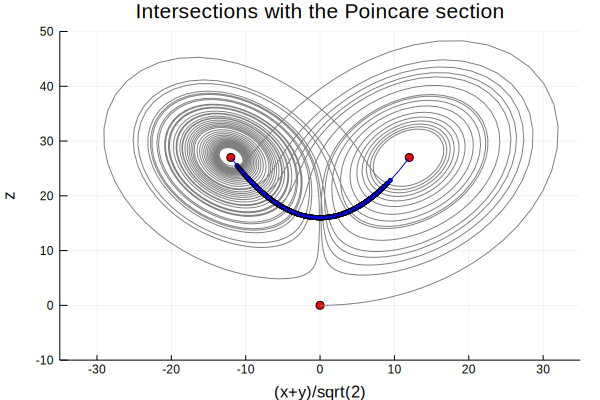

In [10]:
# Calculate and plot a series of successive Poincare intersections

# define Poincare section
z₀ = 16
h(x) = x[3] - z₀ - (ρ-1-z₀)/(4β*(ρ-1)) * (x[1]+x[2])^2


hz(x) = z₀ + (ρ-1-z₀)/(4β*(ρ-1)) * (x[1]+x[2])^2

# calculate 1000 Poincare intersection
X = F(f, x₀, Δt, 1000, h)

a = 1/sqrt(2)
plot( [a*(eq0[1]+eq0[2])], [eq0[3]], marker=:circ, color=:red)
plot!([a*(eq1[1]+eq1[2])], [eq1[3]], marker=:circ, color=:red)
plot!([a*(eq2[1]+eq2[2])], [eq2[3]], marker=:circ, color=:red)
plot!(a*(x[:,1].+x[:,2]), x[:,3], linecolor=:grey)
plot!(a*(X[:,1].+X[:,2]), X[:,3], marker=:circ, markersize=2, color=:blue, linecolor=nothing)

linspace(a,b,N) = collect(a .+ (0:N-1)*((b-a)/(N-1)))

xn = linspace(-sqrt(β*(ρ-1)), sqrt(β*(ρ-1)), 30)
yn = xn
zn = z₀ .+ (ρ-1-z₀)/(4β*(ρ-1)) * (xn+yn).^2

plot!(a*(xn .+ yn), zn, color=:blue)
plot!(legend=false)
plot!(xlim=(-35,35), ylim=(-10,50))
plot!(xlabel="(x+y)/sqrt(2)", ylabel="z")
plot!(title="Intersections with the Poincare section")

## Approximate 1d return map on Poincare section

Project the Poincare sections onto a 1d coordinate $\xi = c(x+y)$ where $c$ is a 
normalization constant that puts $\xi$ in $[-1,1]$, then plot $\xi_{n+1}$ versus $\xi_n$
to get an approximate 1d return map.

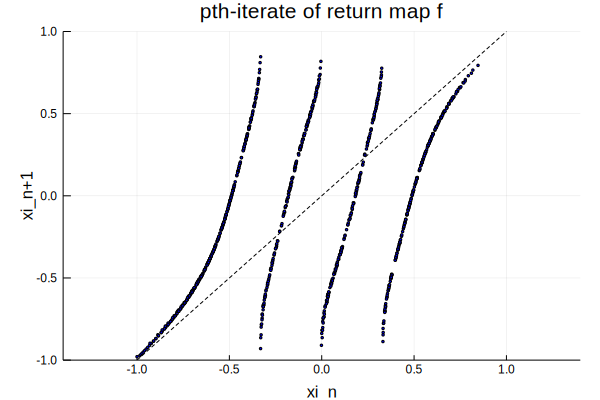

In [12]:
p = 2 # look for period-p orbit via fixed point of pth-iterate return map

#ξ = (X[:,1]+X[:,2])/(2*sqrt(β*(ρ-1)));
ξ = (X[:,1]+X[:,2])/abs(X[1,1]+X[1,2])
N = length(ξ)
p = 2;
plot(ξ[1:N-p], ξ[1+p:N], marker=:circ, markersize=1, markercolor=:blue, linecolor=false)
plot!([-1.0; 1.0], [-1.0; 1.0], linecolor=:black, linestyle=:dash)
plot!(xlabel="xi_n", ylabel="xi_n+1", legend=false)
plot!(xlim=(-1.4,1.4), ylim=(-1,1))
plot!(title="pth-iterate of return map f")
#plot!(xlim=(-0.2,-0.1), ylim=(-0.2,-0.1))

### Find an approximate fixed point of iterated return map

In [13]:
# Find the closest recurrence of the pth iterate of f
perm = sortperm(abs.(ξ[1:N-p]-ξ[1+p:N]));
@show perm[1:3]
k = perm[1]

perm[1:3] = [508, 498, 2]


508

In [14]:
ξ[k]

-0.22787372849581106

In [15]:
ξ[k+p]

-0.21792346953276562

### Get the corresponding value of (x,y,z) from the Lorenz time series data

This serve as an initial guess for our periodic orbit search

In [16]:
xguess = X[k,:]

3-element Array{Float64,1}:
 -1.5586711018344062
 -2.0401056123381784
 16.49466359932532  

In [17]:
X[k+p,:]

3-element Array{Float64,1}:
 -1.2339615534871968
 -2.2076721653406954
 16.45240698747825  

In [18]:
h(X[k,:])

-5.42273841386276e-8

In [20]:
@show xguess
F(f, xguess, Δt, p, h) 

xguess = [-1.55867, -2.04011, 16.4947]


2×3 Array{Float64,2}:
  1.32043   2.33993  16.5117
 -1.23396  -2.20767  16.4524

### Plot the approximate periodic orbit

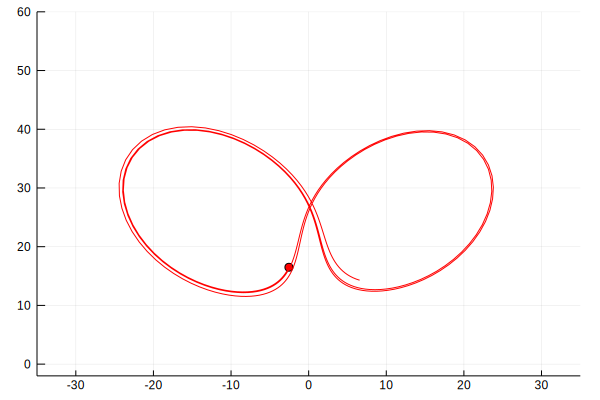

In [21]:
t,xorbguess = rungekutta4(f, xguess, Δt, 4.0);
plot([(xguess[1] + xguess[2])/sqrt(2)], [xguess[3]], marker=:circ, color=:red, linewidth=2)
plot!((xorbguess[:,1].+xorbguess[:,2])/sqrt(2), xorbguess[:,3], color=:red, linewidth=1)
#plot!((x[:,1].+x[:,2])/sqrt(2), x[:,3], color=:grey)
plot!(xlim=(-35,35), ylim=(-2,60), legend=false)

### Use nonlinear solver to refine guess into periodic orbit

In [22]:
using NLsolve
xguess

3-element Array{Float64,1}:
 -1.5586711018344062
 -2.0401056123381784
 16.49466359932532  

In [23]:
xguessnext = F(f, xguess, Δt, p, h)

2×3 Array{Float64,2}:
  1.32043   2.33993  16.5117
 -1.23396  -2.20767  16.4524

In [24]:
xguess - xguessnext[p,:]

3-element Array{Float64,1}:
 -0.3247094002760995 
  0.16756678156392368
  0.04225646669070571

In [25]:
norm(xguess - xguessnext[p,:])/norm(xguess)

0.022034746229939322

In [26]:
# g(x) = F(x) - x, where F(x) is nth iterate of return map on Poincare section. 
# Thus roots of g(x) == 0 are periodic orbits
function g!(gx, x) 
  
    # compute nth iterate of Poincare map
    X = F(f, [x[1]; x[2]; hz(x)], Δt, p, h) 

    # return x,y components of F(x) -x 
    gx .= X[p,1:2] - x
end

g! (generic function with 1 method)

In [27]:
gx = [0.0; 0.0]
g!(gx, xguess[1:2])

2-element Array{Float64,1}:
  0.32470935366058096
 -0.16756685295753737

In [28]:
soln = nlsolve(g!, xguess[1:2])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-1.55867, -2.04011]
 * Zero: [-1.29318, -2.29829]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [29]:
soln.zero

2-element Array{Float64,1}:
 -1.2931837626066331
 -2.298288639792282 

In [30]:
xorb₀ = vcat(soln.zero, hz(soln.zero))

3-element Array{Float64,1}:
 -1.2931837626066331
 -2.298288639792282 
 16.49265768815668  

In [31]:
h(xorb₀)

9.992007221626409e-16

In [32]:
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
  1.29318   2.29829  16.4927
 -1.29318  -2.29829  16.4927
  1.29318   2.29829  16.4927
 -1.29318  -2.29829  16.4927
  1.29319   2.29829  16.4927
 -1.29318  -2.29828  16.4927
  1.29319   2.29831  16.4927
 -1.29316  -2.29825  16.4926
  1.29323   2.29837  16.4927
 -1.29308  -2.29812  16.4926

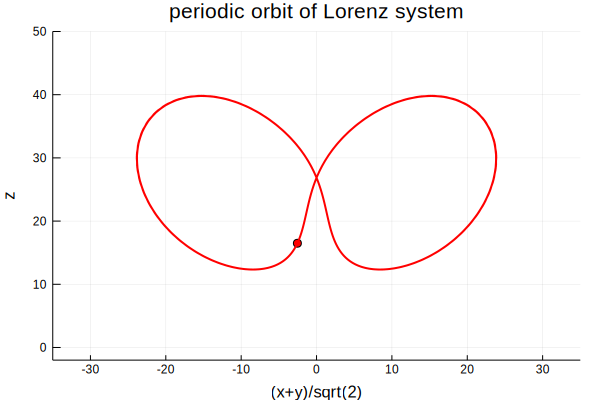

In [33]:
t, xorb = rungekutta4(f, xorb₀, Δt, 6.0)

plot([(xorb₀[1].+xorb₀[2])/sqrt(2)], [xorb₀[3]], marker=:circ, color=:red, linewidth=3)
plot!((xorb[:,1].+xorb[:,2])/sqrt(2), xorb[:,3], color=:red, linewidth=2)
plot!(xlim=(-35,35), ylim=(-2,50), legend=false)
plot!(title="periodic orbit of Lorenz system",xlabel="(x+y)/sqrt(2)",ylabel="z")
#plot!((x[:,1].+x[:,2])/sqrt(2), x[:,3], color=:grey)